In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# enable interactive plots
%matplotlib notebook

In [2]:
def rssiToDistance(rssi):
    return np.power(10, (t - rssi) / k)

def calc_error(y, prediction):
    d = y - prediction
    d = np.square(d)
    e = np.sum(d)
    return e

def get_file(path):
    return pd.read_csv(path,sep=';')[['time_ms','rssi_median', 'distance_median']]

In [3]:
all_measures = [
    [get_file('data/samuel.txt'), 25, '%Y-%m-%d %H:%M:%S', 'Samuels Handy'],
    [get_file('data/xiaomi_a2_lite__1.txt'), 19, '%H:%M:%S', 'Xiaomi'],
    [get_file('data/samsung_s5__1.txt'), 24, '%H:%M:%S', 'Samsung'],
#     [get_file('data/samsung_s5__2.txt'), 24, '%H:%M:%S', 'Samsung'],
]

In [4]:
k = 30 # env_factor
t = -56 # base_power

actual_dist = []
rssi = []

for df in all_measures:
    # Calculate time and distances based on it
    times = df[0]['time_ms'].to_numpy()
    first_time = datetime.strptime(times[0], df[2])

    for idx,item in enumerate(times):
        current_time = datetime.strptime(item, df[2])
#         times[idx] = str(current_time - first_time)
        actual_dist.append(int(np.floor((max((current_time - first_time).seconds - 1, 0)/30))))
    
    rssi = [*rssi, *(df[1] + df[0]['rssi_median'].to_numpy())] #get rssi

predictions = []
rssi = np.array(rssi)
actual_dist = np.array(actual_dist)

# learn rate
alpha = 0.5 / len(rssi)

tx_power = 25

# train for 30 iterations
for i in range(1000):


    # prediction with input data
    dist_pred = rssiToDistance(rssi)
    

    # partial derivative
    t_deri_sum =  np.sum((2*np.log(10)*np.power(10, (t-rssi)/k)*(np.power(10, (t-rssi)/k) - actual_dist))/k)
    k_deri_sum = np.sum(-(2*np.log(10)*(t-rssi)*np.power(10, (t-rssi)/k)*(np.power(10, (t-rssi)/k) - actual_dist))/np.power(k,2))    

    # update theta
    t = t - alpha * t_deri_sum
    k = k - alpha * k_deri_sum

    # print error
    if (i % 1000 == 0): 
        print("{:2d} error: {:5.3f}".format(i, calc_error(actual_dist, dist_pred)))


    # remember the current predictions 
    predictions.append(dist_pred)

print(k, t)


 0 error: 1724.185
50.00106979068839 -34.71371348124142


<IPython.core.display.Javascript object>


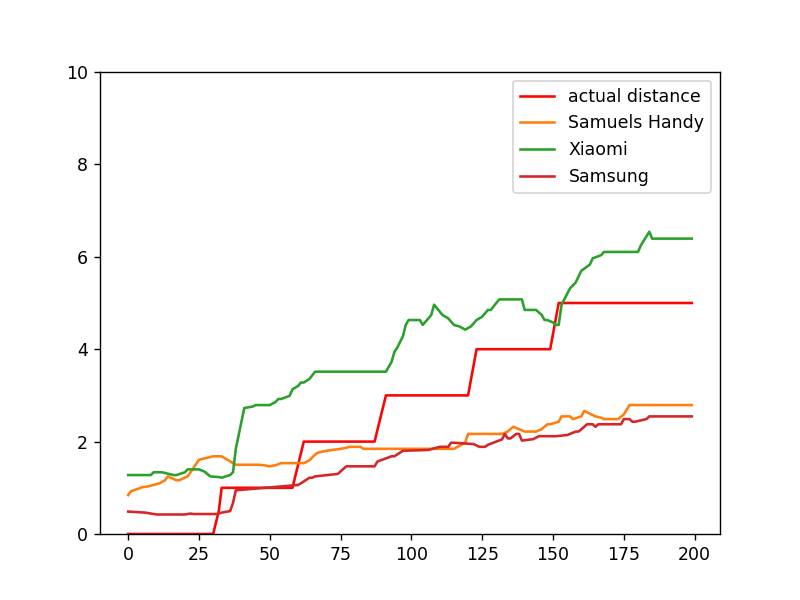

In [5]:

def nan_helper(x,y):
    nans, x= np.isnan(y), lambda z: z.nonzero()[0]
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y


def fill_missing(x,y):
    x_tmp = x.tolist()
    y_tmp = y.tolist()
    x_filled = []
    y_filled = []
    for sec in range(200):
        if len(x_tmp) == 0:
            x_filled.append(sec)
            y_filled.append(np.nan)
        elif x_tmp[0] == sec:
            x_filled.append(x_tmp.pop(0))
            y_filled.append(y_tmp.pop(0))
        elif x_tmp[0] <= sec:
            x_tmp.pop(0)
            y_tmp.pop(0)
        else:
            x_filled.append(sec)
            y_filled.append(np.nan)
    return x_filled, nan_helper(np.array(x_filled), np.array(y_filled))


fig=plt.figure()
axes = plt.gca()
axes.set_ylim([0,10])
    
for idx_measure, df in enumerate(all_measures):
    # Calculate time and distances based on it
    times = df[0]['time_ms'].to_numpy()
    first_time = datetime.strptime(times[0], df[2])
    
    actual_dist = []
    rssi = []
    
    for idx,item in enumerate(times):
        current_time = datetime.strptime(item, df[2])
        times[idx] = (current_time - first_time).seconds
        actual_dist.append(int(np.floor((max((current_time - first_time).seconds - 1, 0)/30))))
    
    rssi = [*rssi, *(df[1] + df[0]['rssi_median'].to_numpy())] #get rssi    

    x, y = fill_missing(times, rssiToDistance(rssi))
    
    if idx_measure == 0:
        plt.plot(x, fill_missing(times, np.array(actual_dist))[1], color="#fc0505", label="actual distance")
    plt.plot(x, y, color="C" + str(idx_measure + 1), label=df[3])





    
plt.legend()
plt.show()

